*Author & point of contact: Piotr Kaniewski (piotr@everycure.org) 27.08.2024*

# Neo4j GraphSage Optimization - e2e run troubleshooting - executive summary



We noticed our graphsage produces weirdly looking topological embeddings which likely impact downstream performance. Below you can see PCA plot for OpenAI embeddings (same trend was observed for a subsample of PubMedBERT embeddings which run through GraphSAGE)

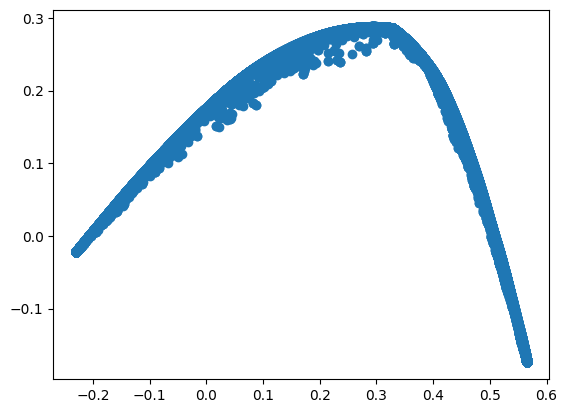

In [27]:
pre-troubleshoot-pca-openai


The same trend was observed when I run GRaphsage on my subsamples:

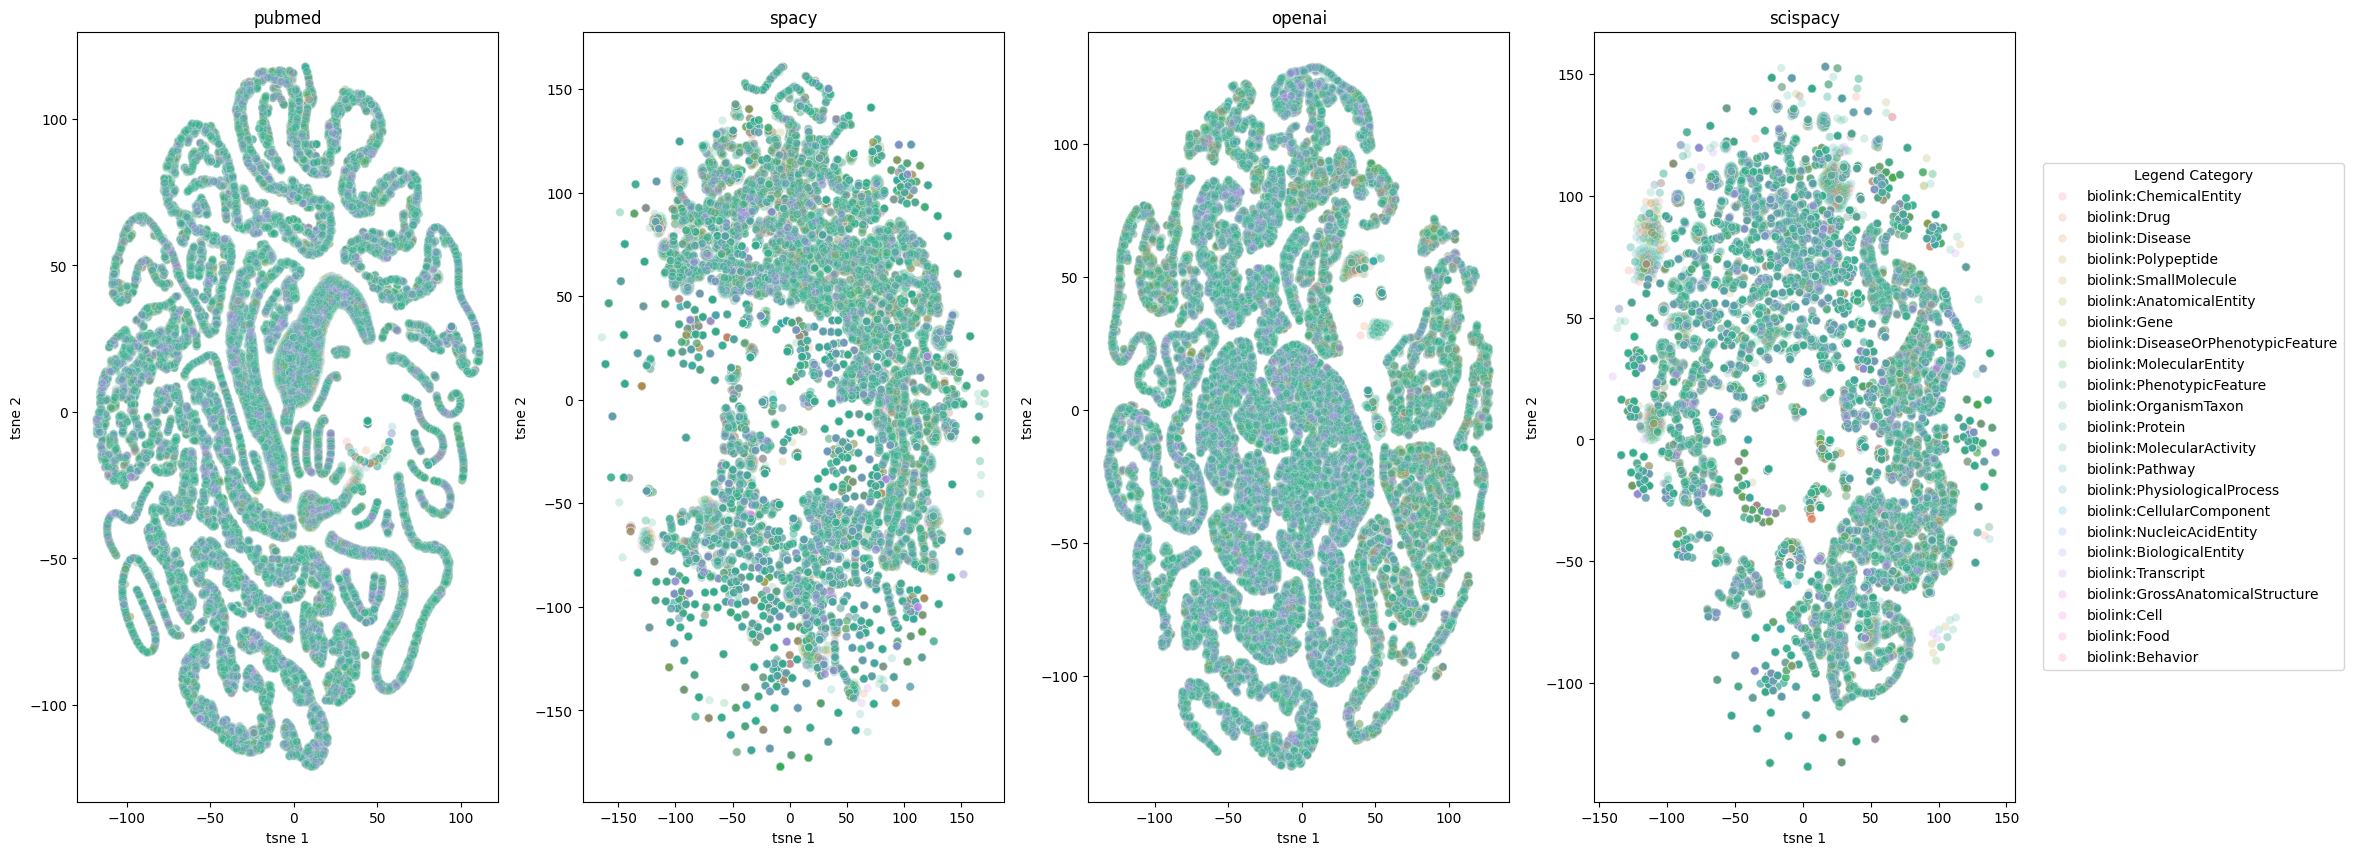

In [26]:
topological_subsample_images


While the clustered lines could capture connectivity between nodes in the graph (which would make sense as GraphSAGE is supposed to enrich our nodes with this connectivity), this is really different from how Chunyu's embeddings looked like (see below for PCA): 

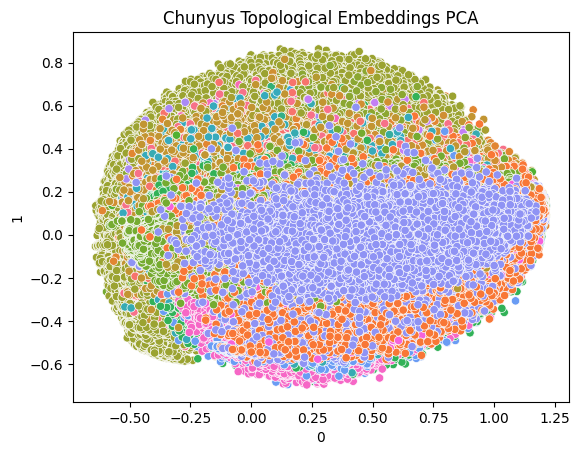

In [24]:
chunyu_topological_pca

Clearly we get relatively nice clusters even after topological enrichment. The weird-shapes of PCA are also consistent with downstream task performance of our pipeline as the run executed on 07-08-2024 resulted in poor performance.


In [29]:
df


run  macro F1  hit@1  hit@3  hit@10   mrr
0  20240807       0.7   0.04   0.13    0.19  0.13

This implies that **our GraphSAGE is not working properly** as it should 
1) produce informative clusters 
2) yield in good downstream task performance (1:1 reproduction wont be possible as we use OpenAI embeddings instead of PubMedBERT but similar results should be achievalble). 

To fix this I experimented with different parameters of GraphSAGE on a subsample of data to understand how is our GraphSAGE (neo4j) different from Chunyu's (original GraphSAGE)

*Note: we could technically reproduce Chunyus graphsage implementation 1:1 however this would be quite difficult as it uses really old python version (2.7) which is incompatible with our pipeline and heavily outdated; there are some other libraries out there which implement GraphSAGE (eg stellargraph) but one of the challenges is compatibility with neo4j*


## Exploratory data analysis
*For more thorough report see graphsage-exploration/pk-240822-e2e-troubleshoot/graphsage_neo4j_eda.ipynb*

Before troubleshooting we were using different parameters than Chunyus:
* Chunyu's parameters - LR 0.001, SampleSize [96,96], BatchSize - 200, MaxIter - 10k
* Our parameters - LR 0.1, SampleSize [25,10], BatchSize - 20000, MaxIter - 10

However this didn't improve our results, we still got wiggly lines even when we increased MaxIterations to 100 or 500 and decreased the learning rate. 

This led us to think that the issue can be on neo4j implementation side. After digging in their code and contacting them on github, we confirmed that there are some limitations/restrictions of their java implementation - the largest one being that Sigmoid Activation Function was applied by default across all layers (contrary to ReLU which was applied in original GraphSage and is applied in 99% of modern algorithms).  Below I compared ReLU activation function with non-ReLU activaiton:



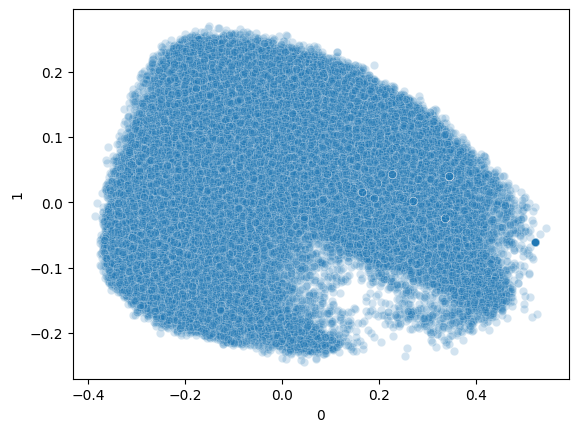

In [36]:
#Pubmed Topological Embeddings after 1 epoch and 1 iteration, ReLU activation

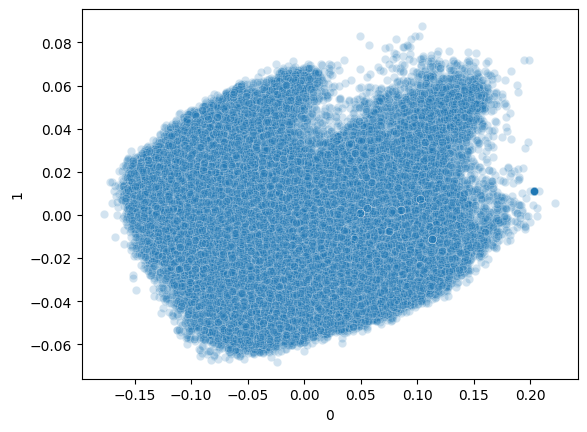

In [35]:
#Pubmed Topological Embeddings after 1 epoch and 1 iteration, sigmoid activation

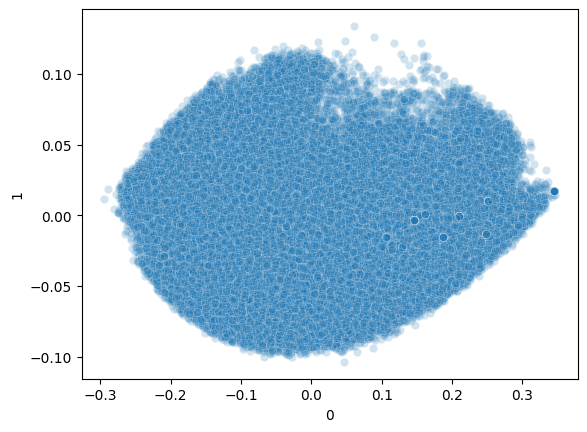

In [34]:
#Pubmed Topological Embeddings after 1 epoch and 10 iteration, sigmoid activation


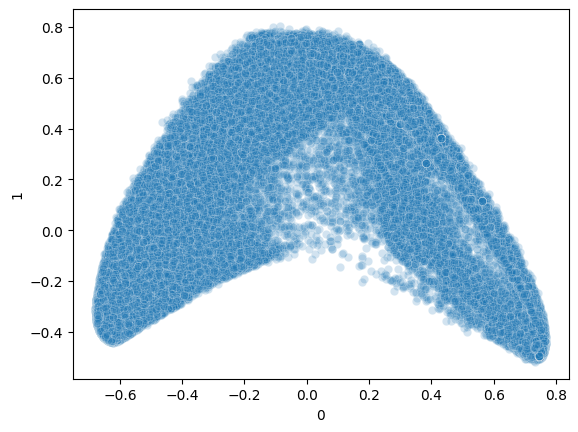

In [32]:
#Pubmed Topological Embeddings after 1 epoch and 10 iteration, ReLU activation
image

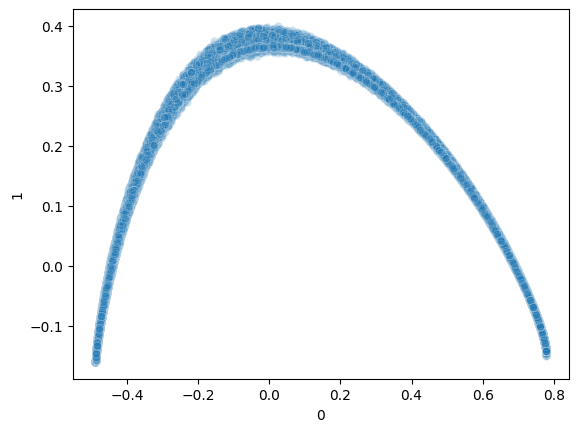

In [31]:
# Pubmed Topological Embeddings after 2 epoch and 10 iteration, sigmoid activation 

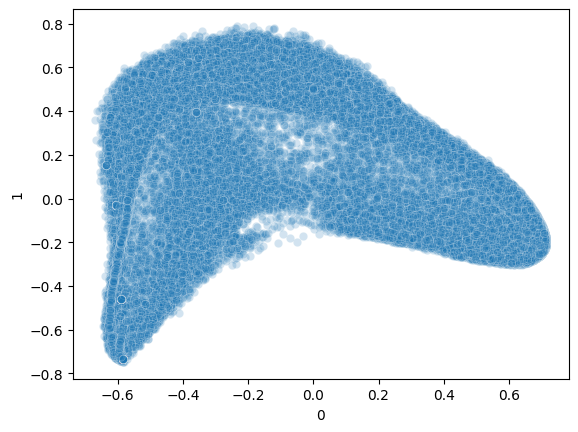

In [30]:
# Pubmed Topological Embeddings after 2 epoch and 10 iteration, ReLU activation



non-Relu activation functions are known to lead to vanishing gradient which lead to ML models losing information the more we train them. This is consistent with the figures above - when we have few iterations/epochs, we dont see the difference but as we increase the iterations, we 'squish' the values between 0 and 1 increasingly more often -> this is consistent with very low variance and also squiggly clusters



## Downstream task performance analysis
*For more thorough report see graphsage-exploration/pk-240822-e2e-troubleshoot/graphsage_neo4j_downstream_clf.ipynb*

As mentioned, our model from pre-troubleshooting showed much worse performance . Below are the results for 20240807 run with our old parameters.


In [5]:
df

run  macro F1  hit@1  hit@3  hit@10   mrr
0  20240807       0.7   0.04   0.13    0.19  0.13


These results are much worse than Chunyu's model (which was obtained using PubMedBERT embeddings and custom graphsage)


In [6]:
df

run  macro F1  hit@1  hit@3  hit@10   mrr
0  chunyu      0.91    0.2    0.4    0.56  0.35

One of the runs we executed (a bit randomly) yielded good results - note that parameters in this case were similar to our initial pre-troubleshooting parameters but we only trained it for one epoch and one iteration -> basically no training at all. Below are the results for 20240820:

In [8]:

df

run  macro F1  hit@1  hit@3  hit@10   mrr
0  20240820      0.91   0.21   0.45    0.56  0.36

While the random run was good enough to actually yield slightly different clusters and good results, it made me check check the downstream task performance on only node attribute embeddings. This is where we can see the performance was mainly due to OpenAI encoding data leakage:

In [10]:
df

run  macro F1  hit@1  hit@3  hit@10   mrr
0  openai_node      0.87   0.23   0.45    0.54  0.37

While this shows the power of LLMs and how much contextual information they contain, This also shows a very clear data leakage which is also much more visible than in case of PubMedBERT. In this case it is difficult to say how much of enrichment comes from a graph or not - seems like most of it is coming from LLMs


## Long Covid e2e runs
The exploration done indicated we need to swap sigmoid activation with ReLU. We kicked off 6 experiments with varying parameters (you can see [MLFlow results](https://mlflow.platform.dev.everycure.org/#/experiments/0?searchFilter=&orderByKey=attributes.start_time&orderByAsc=false&startTime=ALL&lifecycleFilter=Active&modelVersionFilter=All+Runs&datasetsFilter=W10%3D) - lc-baseline-run-run-23-aug-setup 1-6).

These e2e runs yielded much better results both PCA-wise and downstream-task performance wise consistently across different setups, showing that ReLU was the real game-changer. We even managed to beat Chunyus performance with one of the runs in terms of ranking (setup 3)



In [11]:
df


Metric  AUROC    AP  MRR  HIT2  HIT10  HIT100   ACC    F1
0  XG Ensemble Run 3    0.9  0.04  0.2  0.18   0.31    0.62  0.86  0.78

Below you can see really nice clusters 

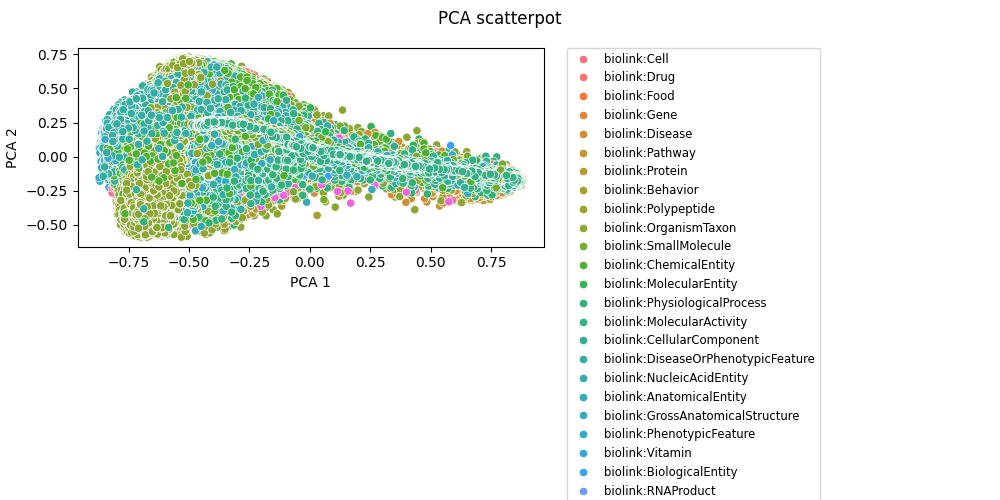

In [37]:
image = Image.open("../../img/pca_plot_run3_e2e.png")
image


The clusters differ a lot from node embeddings clusters as well as previous topological clusters which were obtained using Sigmoid Activation function. This is good news as it means there is some clear topological enrichment happening. However this analysis higlighted the issue of data leakage present in the OpenAI embeddings (or LLM embeddings in general).



## Conclusion

Chunyus parameters for his graphsage won't fit our graphsage - this is because of compute as well as different implementations of the algorithm (activation layers, the way they sample and preprocess data). Nevertheless, parameters such as **learning rate, max iterations, and num epochs** should be taken into account the most when optimizing the model to ensure we capture the most informative topological embeddings.
 
We need to always choose ReLU activation function as a parameter when working with GraphSAGE in neo4j. We also need to be aware of other neo4j limitations such as 
* java vs python differences in random seeding and back propagation
* neo4j graphsage parameter for number of neurons in the hidden layers also defines the dimension of the output (contrary to the custom graphsage)

Additionally we need to find methods which dont rely on LLMs as they can clearly encode target information in the training set and lead to data leakage, making our model not reliable.

## References
* For codebase see [lab-notebooks repo](graphsage-exploration/pk-240822-e2e-troubleshoot)
* For matrix github issue - see [issue #214 in matrix](https://github.com/neo4j/graph-data-science/issues/324)
* For neo4j issue - see [issue #324 in graph-data-science](https://github.com/neo4j/graph-data-science/issues/324)